# Lab 2

<b>Class:</b> MSDS 7331 Data Mining
<br> <b>Dataset:</b> Belk Endowment Educational Attainment Data 

<h1 style="font-size:150%;"> Teammates </h1>
Maryam Shahini
<br> Murtada Shubbar
<br> Michael Toolin
<br> Steven Millett

In [1]:
#Set global variables
#Variables for file and school informaiton

YEARS = ['2014', '2015', '2016', '2017']

#Number of features we will be selecting for feature selection

N_FEATURES_OPTIONS = [25,50,100,"all"]

#Alpha and C we will be using for our classifiers

C_ESTIMATORS = [50, 100, 200, 500]
C_DEPTH = [2, 3, 5]
LEARNING_RATE = [1e-2, 1e-1, 1e0]

#Used for KNN gridsearch
C_NEIGHBORS = [4, 5]

#Used for SVC grid search
C_OPTIONS = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]

#Import data all necessary libraries we will be using in our estimation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
import sklearn
import statistics
import random
from IPython.display import Image


from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile, RFE, SelectFromModel

from sklearn.preprocessing import StandardScaler, Binarizer

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, auc, roc_curve
from IPython.display import display, HTML

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, TimeSeriesSplit, StratifiedShuffleSplit

from sklearn.naive_bayes import MultinomialNB

from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor,AdaBoostClassifier,RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline


<style>
%%html
table {float:left}
</style>

# 1.a Data Preparation


# The Belk Endowment Educational Attainment Data Repository for North Carolina Public Schools
Our data set originates from the North Carolina Public Schools Reports and Statistics. This public site contains large amounts of information covering many aspects of the performance of students and schools across the state of North Carolina. It includes public and charter schools ranging from the elementary level to high schools. http://www.ncpublicschools.org/

The data used in our lab consists of portions of this data which includes the school years 2014-2017. The data used is the result of combining and cleaning the raw data sets available on the North Carolina website. The machine learning data sets are broken down by school year and then sub-sectioned by elementary school, middle school and high school information. 

In this lab our data set consists of all the data available for school years 2015-2017 from the Machine Learning data available.  First step is to combine all the data from previous years and add the variable ‘Year’ to each row, keeping track of which year this data was collected.

Next each feature is inspected for NA values.  If more than 75% of the feature contains NA, we replace that field with 0.  If less than 75% is NA, then the median value of the column is used to replace the NA.

Two binary classifications are performed.  
1. The first is classifying if a schools average SAT score will be above 1000.  This information is useful to teachers and guidance counselors as they are helping students navigate college searches.  


2. The second classifier examines crime rate as compared to the LEA each school is in. We wanted to measure the factors that can prevent crime at a school, compared to the surrounding area. Crime during the high school years can have long-term effects on the student population including disrupting the education process along with impacting the surrounding community.

Source: https://www.usnews.com/news/articles/2014/06/10/incidents-of-school-crime-and-violence-on-the-rise-for-students-and-teachers



|<p align="">Variable|<p align="">Type|<p align="">Note|
|--------|----|----|
|<p align="">Year|<p align="">Object|<p align="">Tracks year data is from|
|<p align="">local_crime_greater|<p align="">int64|<p align="">1 if crime in school is above LEA average crime, 0 otherwise
|<p align="">X_crime_reduced|<p align="">Data Frame|<p align="">Used in crime reduced scope model, removes racial information from data|
|<p align="">SAT_Score_Above1000|<p align="">int64|<p align="">1 if SAT score is above 1000 ,0 otherwise.
<BR>
    
Additional features we deem important: 

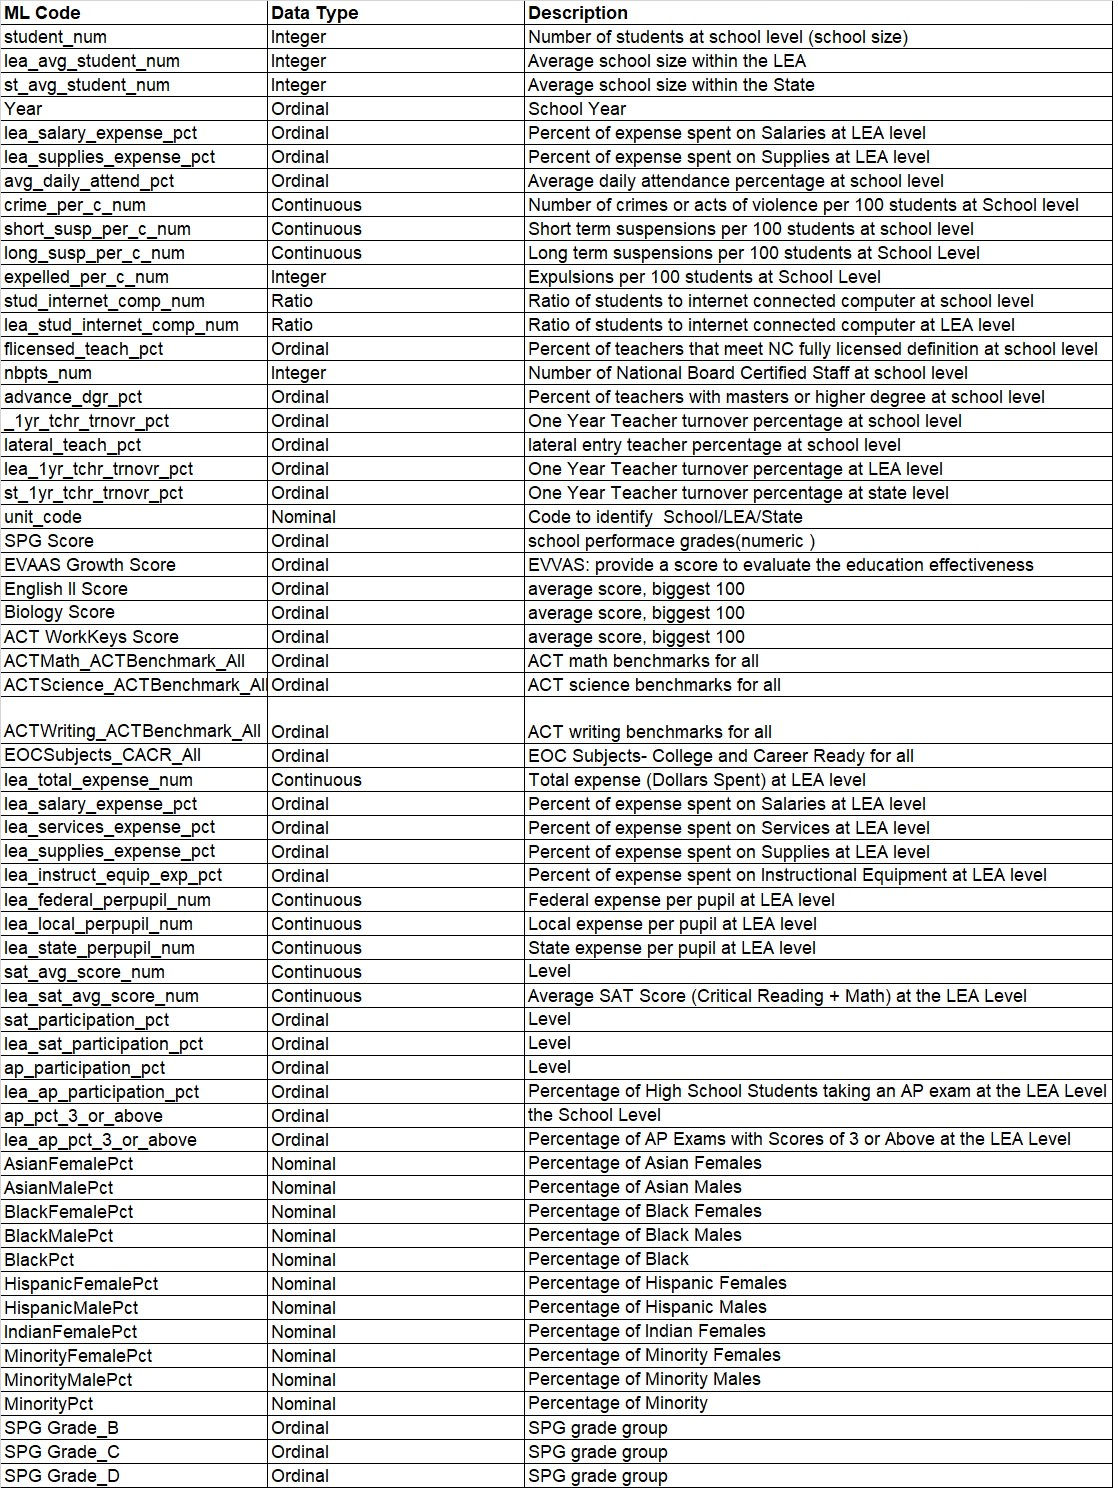

In [2]:
display(Image('https://i.imgur.com/9FOnBf2.jpg', width=700, unconfined=True))

#### Preprocessing
For preprocessing, much of this is done during our model selection step as a part of the pipeline. This was done as we are using grid search cross-validation for our model selection. This method of cross-validation will try different means of dimensionality reduction to ensure we are using the best method for reduction, for the given classifier. We have found that different classifiers work best with different preprocessing steps and parameters.

# 1.b Data Preparation

In [3]:
# All years of the High School Public Schools Machine Learning 
# Date Set is being used throughout this 
# analysis. 
# Load Full Public School Data Frames for each year

school_data = pd.DataFrame()

for year in YEARS:
    #Load public school master file
    temp_year = pd.read_csv('../Data/'+str(year)+'/Machine Learning Datasets/PublicHighSchools'+str(year)+'_ML.csv', low_memory=False)
        
    #Add year column and concatonating all data together
    temp_year['Year']=year
    
    if(school_data.empty):
        school_data = pd.concat([school_data,temp_year],ignore_index=True)
    else:
        school_data = pd.concat([school_data,temp_year], join = "inner",ignore_index=True)


### Impute any missing values

Here we are setting the master dataset that we will be taking a subset of the data for the rest of the paper. This dataset is made up of the 4 years of high school data available from 2014 until 2017, which were combined to a single DataFrame. An inner join was performed to that only columns of data that were present in all imported spreadsheets were kept in the final DataFrame.

A column was added to the data to note which year the data came from. Many of the same schools will be represented multiple times through the years. 

In [4]:
#This is the critical threshold
CRITICAL_NA = .75

#With this we check if the column is less than 75% non-NA, if it is greater than 75% non-NA
#We replace the NA with the median of the column, otherwise we replace the value with 0

imputed_school_data = school_data.apply(lambda col: col.fillna(0) if col.count()/col.shape[0]<CRITICAL_NA else col.fillna(col.median()),axis=0)


#Print the shape and basic statistics for school_data
print(imputed_school_data.shape)
imputed_school_data.describe()


#This is the master data set! 

(1904, 288)


,student_num,lea_avg_student_num,st_avg_student_num,Biology_Size,English II_Size,Math I_Size,lea_total_expense_num,lea_salary_expense_pct,lea_services_expense_pct,lea_supplies_expense_pct,...,grade_range_cd_PK-12,"calendar_type_txt_Regular School, Year-Round Calendar",esea_status_P,Grad_project_status_Y,SPG Grade_B,SPG Grade_C,SPG Grade_D,EVAAS Growth Status_Met,EVAAS Growth Status_NotMet,unit_code
count,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,...,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000
mean,849.853466,830.111870,828.354517,18.629727,19.313550,18.243172,9093.345021,0.670409,0.081126,0.081555,...,0.006828,0.019433,0.034664,0.398109,0.340336,0.398109,0.087185,0.333508,0.309349,510742.404937
std,588.307262,357.643945,105.106371,5.607309,5.510312,5.544849,1204.493613,0.095046,0.016536,0.015932,...,0.082369,0.138077,0.182975,0.489637,0.473947,0.489637,0.282180,0.471590,0.462347,279912.990415
min,8.000000,105.000000,252.000000,0.000000,0.000000,0.000000,7282.190000,0.547000,0.047000,0.028000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10303.000000
25%,326.500000,584.500000,837.000000,16.000000,17.000000,16.000000,8362.900000,0.611000,0.069000,0.071000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,280330.000000
50%,783.500000,810.000000,848.000000,19.000000,20.000000,19.000000,8820.080000,0.626000,0.080500,0.081000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,490380.000000
75%,1221.250000,974.000000,853.000000,23.000000,23.000000,22.000000,9405.800000,0.655000,0.089000,0.091000,...,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,761304.000000
max,2966.000000,1852.000000,860.000000,32.000000,35.000000,37.000000,17801.850000,0.878000,0.153000,0.143000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,995330.000000


In [5]:
imputed_school_data.sample(5)

,student_num,lea_avg_student_num,st_avg_student_num,Biology_Size,English II_Size,Math I_Size,lea_total_expense_num,lea_salary_expense_pct,lea_services_expense_pct,lea_supplies_expense_pct,...,"calendar_type_txt_Regular School, Year-Round Calendar",esea_status_P,Grad_project_status_Y,SPG Grade_B,SPG Grade_C,SPG Grade_D,EVAAS Growth Status_Met,EVAAS Growth Status_NotMet,unit_code,Year
1643,990.0,577.0,853.0,17.0,16.0,15.0,9169.76,0.851,0.060,0.079,...,0,0,0,1,0,0,1,0,440378,2017
1569,504.0,504.0,278.0,14.0,16.0,21.0,9248.40,0.810,0.079,0.094,...,0,0,1,0,1,0,0,0,310364,2017
1901,575.0,552.0,853.0,17.0,19.0,18.0,9583.92,0.874,0.054,0.060,...,0,0,0,0,1,0,0,1,990326,2017
1416,1064.0,751.0,860.0,16.0,18.0,16.0,8560.08,0.615,0.072,0.092,...,0,0,0,0,0,1,0,1,960380,2016
259,854.0,687.0,837.0,24.0,20.0,23.0,8293.30,0.580,0.103,0.103,...,0,0,1,0,0,1,0,1,540315,2014


### Get the types of the features in the data frame
We want to see the data type of each column of the original school dataset. We set all of the categorical variables to objects, to ensure they are properly handled by our classification algorithms and we do not want these to be scaled in our preprocessing pipeline. 

Next during the import phase, we found that some features were imported as the wrong numeric type, where some integer were incorrectly imported as floats. These were all converted back to integers to ensure proper handling of the data in our pipeline.


In [6]:
imputed_school_data.info()
print('\n')
print(imputed_school_data.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904 entries, 0 to 1903
Columns: 288 entries, student_num to Year
dtypes: float64(266), int64(21), object(1)
memory usage: 4.2+ MB


student_num                                              float64
lea_avg_student_num                                      float64
st_avg_student_num                                       float64
Biology_Size                                             float64
English II_Size                                          float64
Math I_Size                                              float64
lea_total_expense_num                                    float64
lea_salary_expense_pct                                   float64
lea_services_expense_pct                                 float64
lea_supplies_expense_pct                                 float64
lea_instruct_equip_exp_pct                               float64
lea_federal_perpupil_num                                 float64
lea_local_perpupil_num               

In [7]:
# Set unit_code to string. We don't want this to be manipulated as a number
# Rather we want to ensure this is taken as a categorical variable
imputed_school_data['unit_code']=imputed_school_data['unit_code'].astype(str)

In [8]:
# Setting all columns that should be an integer to 
for column in imputed_school_data:
    if imputed_school_data[column].dtype == 'float':
        if np.array_equal(imputed_school_data[column], imputed_school_data[column].astype(int)):
            imputed_school_data[column] = imputed_school_data[column].astype(int)

In [9]:
imputed_school_data.info()
print('\n')
print(imputed_school_data.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904 entries, 0 to 1903
Columns: 288 entries, student_num to Year
dtypes: float64(252), int64(34), object(2)
memory usage: 4.2+ MB


student_num                                                int64
lea_avg_student_num                                        int64
st_avg_student_num                                         int64
Biology_Size                                               int64
English II_Size                                            int64
Math I_Size                                                int64
lea_total_expense_num                                    float64
lea_salary_expense_pct                                   float64
lea_services_expense_pct                                 float64
lea_supplies_expense_pct                                 float64
lea_instruct_equip_exp_pct                               float64
lea_federal_perpupil_num                                 float64
lea_local_perpupil_num               

In [10]:
# SAT: adding variables: 

SAT_school_data = imputed_school_data.copy()

SAT_school_data['SAT_Score_Above1000'] = SAT_school_data.apply(lambda each_row: 1 if (each_row['sat_avg_score_num']) > 999 else 0,axis=1)
SAT_school_data['SAT_participation_number'] = SAT_school_data.apply(lambda each_row: (each_row['sat_participation_pct'])*(each_row['student_num']) ,axis=1)
#SAT_school_data['Student_Num_College_Ready_SAT'] = SAT_school_data.apply(lambda each_row: (each_row['SAT_participation_number']) if (each_row['SAT_Score_Above1000'] == 1) else 0,axis=1)

SAT_school_data.describe()

,student_num,lea_avg_student_num,st_avg_student_num,Biology_Size,English II_Size,Math I_Size,lea_total_expense_num,lea_salary_expense_pct,lea_services_expense_pct,lea_supplies_expense_pct,...,"calendar_type_txt_Regular School, Year-Round Calendar",esea_status_P,Grad_project_status_Y,SPG Grade_B,SPG Grade_C,SPG Grade_D,EVAAS Growth Status_Met,EVAAS Growth Status_NotMet,SAT_Score_Above1000,SAT_participation_number
count,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,...,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000
mean,849.853466,830.111870,828.354517,18.629727,19.313550,18.243172,9093.345021,0.670409,0.081126,0.081555,...,0.019433,0.034664,0.398109,0.340336,0.398109,0.087185,0.333508,0.309349,0.435399,411.521127
std,588.307262,357.643945,105.106371,5.607309,5.510312,5.544849,1204.493613,0.095046,0.016536,0.015932,...,0.138077,0.182975,0.489637,0.473947,0.489637,0.282180,0.471590,0.462347,0.495939,379.676251
min,8.000000,105.000000,252.000000,0.000000,0.000000,0.000000,7282.190000,0.547000,0.047000,0.028000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,326.500000,584.500000,837.000000,16.000000,17.000000,16.000000,8362.900000,0.611000,0.069000,0.071000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,133.605000
50%,783.500000,810.000000,848.000000,19.000000,20.000000,19.000000,8820.080000,0.626000,0.080500,0.081000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,314.703500
75%,1221.250000,974.000000,853.000000,23.000000,23.000000,22.000000,9405.800000,0.655000,0.089000,0.091000,...,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,565.942500
max,2966.000000,1852.000000,860.000000,32.000000,35.000000,37.000000,17801.850000,0.878000,0.153000,0.143000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2358.030000


# Get highly correlated features

We are creating a matrix listing all of the variables with greater than 90% correlation. 

From the output it appears that there is a negative correlation between the percentage of minority students and the performance of ACT benchmark results. This relationship could show up for a number of reasons, and if these results are to be used to recommend policy changes, it is important to keep this in mind. Later on, we will see if we see some of these features show up as important in our models. Depending on the result we can take steps to remove these protected classes as a feature from our models and measure the difference in the model’s performance. 

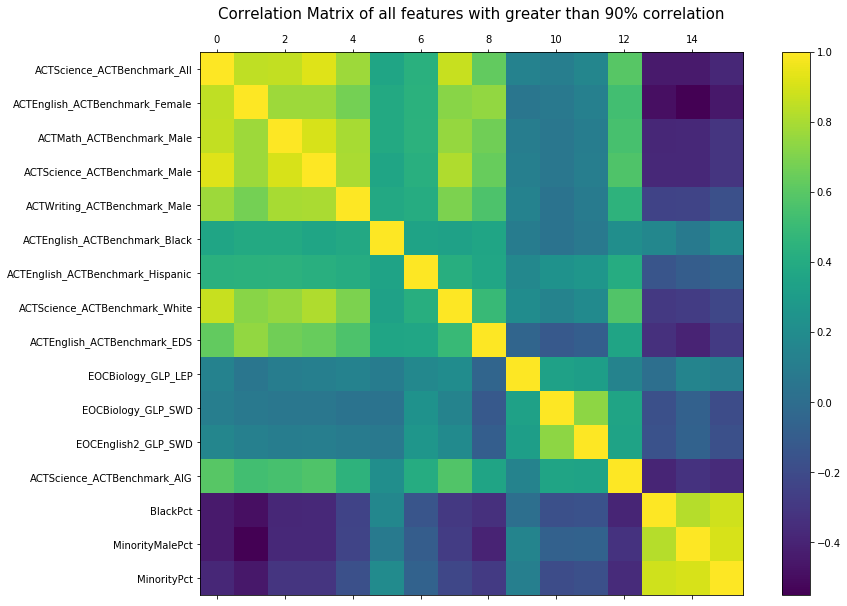

In [11]:
corr_matrix = imputed_school_data.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
highly_correlated = [column for column in upper.columns if any(upper[column] > 0.90)]


fig, ax = plt.subplots(figsize=(14,10))
ax.set_title('Correlation Matrix of all features with greater than 90% correlation',
            fontdict={'fontsize': 15})

cax = ax.matshow(imputed_school_data[highly_correlated].corr());
ax.set_yticklabels(highly_correlated);
ax.set_yticks(np.arange(0, len(highly_correlated), 1.0))
fig.colorbar(cax)
plt.show()

# 2.a Evaluation Metrics
Using the right evaluation metric for classification system is crucial. Otherwise, it may results in thinking that the model is performing well but in reality, it isn’t.

There are two tasks in this section of the $\textbf{NC Educational Data}$ project:

The first task is to predict a binary classification target, either if the average SAT score of each school is good enough to get the student admitted to a North Carolina Universities or not. The SAT is a standardized test widely used for college admissions in the United States. For this purpose we have a cut off 1000 out of 1600. The second task is to predict if the crime per 100 students at each school level is higher than the LEA level or not. 

After considering all evaluation metrics for classification systems, we ended up using ROC Curve. Area under ROC Curve (or AUC for short) is a performance metric for binary classification problems. In fact, a ROC curve can be used to select a threshold for a classifier which maximizes the true positives, while minimizing the false positives.

We usually use ROC when both classes detection are important. Here, our models should be able to decrease both false positive rate (which is identifying the schools with enough good average SAT score for getting admission in different universities) and also decreasing the false negative rate (which is detecting schools with not good average SAT scores).

The same for the second task, it is important to decrease both false positive and false negative rates.

The AUC represents a model’s ability to discriminate between positive and negative classes. An area of 1.0 represents a model that made all predictions perfectly. An area of 0.5 represents a model as good as random. Most classifiers have AUCs that fall somewhere between these two values. Therefore, the overall model performances can be compared by considering the AUC.

Source: https://www.dataschool.io/roc-curves-and-auc-explained/

# 2.b Modeling and Evaluation
Two different data frames based on the same data are used for SAT classification and crime classification. Each data frame is initially split into a training and a test data set. We set aside 20% of the complete data set to test against.  During the training of the model, a standard 10-fold cross validation technique, which will split the data into 10 equal sections, train on nine of the sections and score against the last section. This method will cycle through 10 times so that the each of the 10 sections is used as a holdout sample. We chose to shuffle the data during the cross validation to provide a higher confidence there was no grouping of schools that we did not notice.

Other options available are the Stratified k-fold technique which works to balance the ratio of labels used in each fold.  Our dependent variable (local_crime_greater) has approximately a 45-55% split (see pie chart below), and with a large enough data set we can have a high level of confidence of a random split in the data without using Stratified techniques.  The same held true for the SAT score where the split was approximately 56%-44% (see pie chart below) 

We chose a K fold (10 folds) validation algorithm, however a Shuffle Split may have performed just as well with this size data set. Where Shuffle Split is capable of creating n folds and fitting the data using n-1 to train and 1 to test against, there is a chance the same data will appear in the test set each time the data is sampled. We chose K fold to insure each value is used in the training set.

We chose not use the Leave One Out (LOO) cross validation due to the computational cost on data set as complex as this.  Empirical evidence has shown a 10-fold cross validation is preferred to the LOO algorithm.

Finally, with the 10-fold cross validation we will be using a grid search technique, which will test a number of different parameters to determine the best final model. Different classification algorithms will have different parameters that can be set, so these will be tested with the grid search method.

Grouping algorithms were not relevant to our data set as we do not have groups of dependent variables.

Soure:http://scikit-learn.org/stable/modules/cross_validation.html

# Task 1: Crime - Classification Model

In [12]:
# split X and y into test and train sets. We still want
# to do this for external Cross Validation

crime_imputed_school_data = imputed_school_data

crime_imputed_school_data['local_crime_greater'] = crime_imputed_school_data.apply(lambda each_row: 0 if (each_row['crime_per_c_num']-each_row['lea_crime_per_c_num'])<0 else 1,axis=1)

#split data into X and y dataframes

y_crime = crime_imputed_school_data['local_crime_greater']

#Removed SPG Grade and unit code(which is primary key for school data table)
 
X_crime = crime_imputed_school_data[crime_imputed_school_data.columns.drop(list(crime_imputed_school_data.filter(regex='crime|lea|LEA|^st\_')))]

X_crime_train, X_crime_test, y_crime_train, y_crime_test = train_test_split(X_crime, y_crime, test_size=.2)
y_crime.dtype

dtype('int64')

45.59% of the schools have local crime higher then their local LEA average in the training set


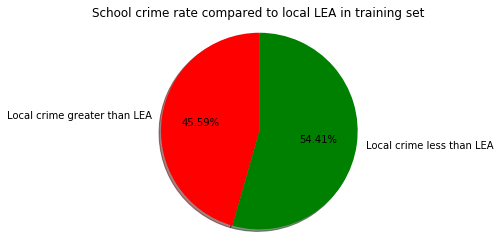

In [13]:
print ('{0:.2%} of the schools have local crime higher then their local LEA average in the training set'.format(y_crime.sum()/len(y_crime)))
labels = 'Local crime greater than LEA', 'Local crime less than LEA',
scores = [(y_crime.sum()/len(y_crime)), 1-(y_crime.sum()/len(y_crime))]
colors = ['red','green']
 
# Plot
plt.pie(scores, labels=labels, colors=colors,
        autopct='%1.2f%%', shadow=True, startangle=90)
 
plt.axis('equal')
plt.title('School crime rate compared to local LEA in training set')
plt.show()

#### High crime going down slightly
The total number of schools whose crime rate is above the 75% percentile has been going down slightly since 2015.  The percentage of schools above the 75% has also been decreasing slightly since 2014.

,Year,Percent
0,2014,11.974790
1,2015,11.554622
2,2016,11.239496
3,2017,10.819328


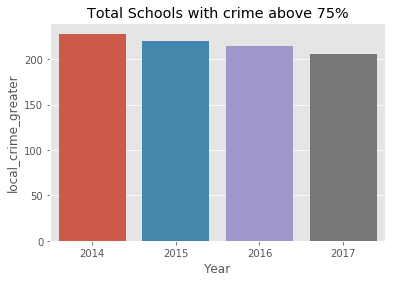

In [64]:
crime_year = crime_imputed_school_data.groupby('Year')['local_crime_greater'].sum()
crime_pct =pd.DataFrame(crime_year/len(crime_imputed_school_data['local_crime_greater']))*100
crime_pct.columns=['Percent']
crime_pct.reset_index(inplace=True)
display (crime_pct)

plt.title('Total Schools with crime above 75%')
plt.xlabel('Year')
sns.barplot(YEARS, crime_year);

#### Overall Crime trends
We look here at the distribution of the crime rate across all four years. Overall crime rates have not been changing over the past four years. We can see that the 75th percentile, the point where we decided a school was high crime, is further away from the mean than the 25% percentile. This is indicating that overall, we have lower percentage of schools with high crime rate than with what may be considered low crime rate (at or below the 25th percentile). We can see we have an outlier in the year 2014. whose total crime rate that year was 7.69. We decided to leave this data point intact as it reflects real circumstances and overall did not affect any of the statistics.

,count,mean,std,min,25%,50%,75%,max
Year,,,,,,,,
2014,476.0,1.110273,0.988202,0.0,0.3950,0.97,1.5325,7.69
2015,480.0,1.121979,0.921185,0.0,0.4475,0.99,1.6625,4.62
2016,478.0,1.043515,0.886198,0.0,0.3800,0.89,1.4675,4.44
2017,470.0,0.989787,0.878575,0.0,0.3300,0.86,1.4300,5.09


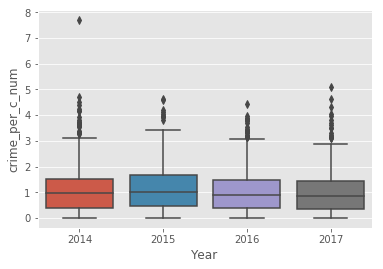

In [59]:
sns.boxplot(x='Year', y=imputed_school_data['crime_per_c_num'],data=imputed_school_data);
imputed_school_data.groupby('Year')['crime_per_c_num'].describe()

# Task 2: SAT Score - Classification Model

In [14]:
# To split X and y into test and train sets.

y_SAT = SAT_school_data['SAT_Score_Above1000']

#Removed SAT_SCore_above1000 and unit code(which is primary key for school data table)
 
X_SAT = SAT_school_data[SAT_school_data.columns.drop(list(SAT_school_data.filter(regex='SAT_Score|SAT_score|SAT_SCORE|sat_avg|unit_code|lea|LEA|^st\_')))]



43.54% of the schools have SAT scores above 1000 in the training set


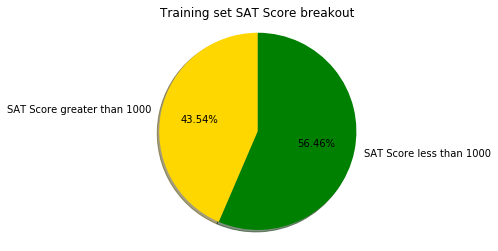

In [15]:
X_SAT_train, X_SAT_test, y_SAT_train, y_SAT_test = train_test_split(X_SAT, y_SAT, test_size=.2)
print ('{0:.2%} of the schools have SAT scores above 1000 in the training set'.format(y_SAT.sum()/len(y_SAT)))
y_SAT.dtype
labels = 'SAT Score greater than 1000', 'SAT Score less than 1000',
scores = [(y_SAT.sum()/len(y_SAT)), 1-(y_SAT.sum()/len(y_SAT))]
colors = ['gold','green']
 
# Plot
plt.pie(scores, labels=labels, colors=colors,
        autopct='%1.2f%%', shadow=True, startangle=90)
plt.title('Training set SAT Score breakout')
 
plt.axis('equal')
plt.show()

#### Increase in SAT data in the last year
There was a significant increase in the last year with schools performing better than the three previous years. Additional research would need to be done to account for this 

,Year,Percent
0,2014,8.665966
1,2015,8.771008
2,2016,9.558824
3,2017,16.544118


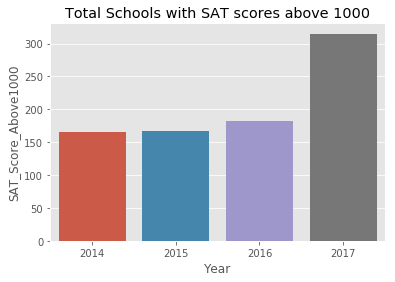

In [63]:
SAT_year = SAT_school_data.groupby('Year')['SAT_Score_Above1000'].sum()
SAT_pct =pd.DataFrame(SAT_year/len(SAT_school_data['SAT_Score_Above1000']))*100
SAT_pct.columns=['Percent']
SAT_pct.reset_index(inplace=True)
display (SAT_pct)

plt.title('Total Schools with SAT scores above 1000')
plt.xlabel('Year')
sns.barplot(YEARS, SAT_year);

#### Overall SAT trends
We can see the median of the average score number held steady for the first three years, with a marked uptick in 2017. This could be attributable to changes in the testing format or other outside forces that are difficult to account for.

,count,mean,std,min,25%,50%,75%,max
Year,,,,,,,,
2014,476.0,929.071429,199.658074,0.0,899.00,962.0,1021.00,1193.0
2015,480.0,935.570833,179.465453,0.0,900.75,965.0,1020.25,1213.0
2016,478.0,946.801255,177.087183,0.0,906.00,971.0,1026.75,1430.0
2017,470.0,943.529787,331.035054,0.0,974.00,1046.0,1100.75,1404.0


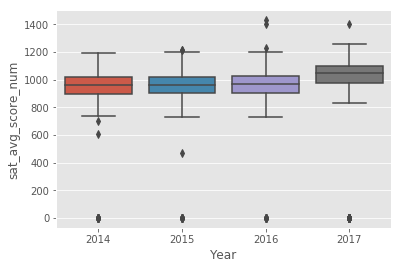

In [61]:
sns.boxplot(x='Year', y=SAT_school_data['sat_avg_score_num'],data=SAT_school_data);
SAT_school_data.groupby('Year')['sat_avg_score_num'].describe()

# 2.c Modeling and Evaluation

We are establishing a basic pipeline that will run our data through three basic steps:
1. Dimensionality Reduction
2. Observation Scaling
3. Model Classification

For steps 1 and 2 we are using the same steps for all models, as we want to focus on the effectiveness of each classification algorithm. First, we will be using the SelectKBest algorithm, which will select the top number of variables from the features, this will be determined through cross-validation. Next the results will be fed into the standardscaler step, which will scale our variables. This improves our prediction outcomes and makes later feature interpretation significantly easier, since all coefficients will be on the same scale.

For all models that take a random state seed, we will be using the same random seed of 123. We want to eliminate the variability of getting different results between running our models so that we are able to hold which model is going to be the best model, for later interpretation.

In [16]:
k_fold = KFold(n_splits=10,shuffle=True)

#This creates the template for the pipeline
# This creates a basic pipeline where we will 
# test for dementionality reduction, scaling,
# and classification.


pipe = Pipeline([ ('reduce_dim',SelectKBest(chi2)),
                  ('scale', StandardScaler()), 
                  ('clf', GradientBoostingClassifier())])

# SAT Models
For the SAT model we tried 5 different algorithms to create a model which has superior prediction capabilities based on the ROC/AUC scoring parameter:
* K-Nearest Neighbor
* SVM
* Random Forest Classification

We created a ROC/AUC plot for each model and summarized our findings based on the combined results for these different models.

# SAT Model #1 : Random Forest Classifier

In [17]:
param_grid = [
    {
         'reduce_dim__k': N_FEATURES_OPTIONS,
         'clf': [RandomForestClassifier()],
         'clf__n_estimators': C_ESTIMATORS, 
         'clf__max_depth': C_DEPTH,
         'clf__random_state':[123]
     }
]

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=k_fold,n_jobs=-1, verbose=1, scoring='roc_auc' )

SAT_RandomForest_model = grid_search.fit(X_SAT_train, y_SAT_train)

y_SAT_score1 = grid_search.predict(X_SAT_test)
y_SAT_prob1=grid_search.predict_proba(X_SAT_test)

print(roc_auc_score(y_SAT_test, y_SAT_prob1[:,1]))

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 338 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   11.9s finished


0.9073350452160323


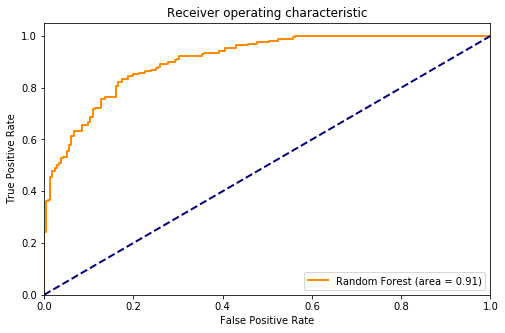

In [18]:
# create ROC cuve for Random Forest model:
fpr1, tpr1, _ = roc_curve(y_SAT_test, y_SAT_prob1[:,1] )
roc_auc1 = auc(fpr1, tpr1)
lw=2

plt.figure(figsize=(8,5));
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label='Random Forest (area = %0.2f)' % roc_auc1)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# SAT Model #2 : KNN Classifier

In [19]:
param_grid = [
    {
         'reduce_dim__k': N_FEATURES_OPTIONS,
         'clf': [KNeighborsClassifier()],
         'clf__n_neighbors': C_NEIGHBORS,
         
    }
]

grid_search = GridSearchCV(pipe, param_grid=param_grid,cv=k_fold,n_jobs=-1, verbose=1, scoring='roc_auc' )

SAT_KNearest_model = grid_search.fit(X_SAT_train, y_SAT_train)

y_SAT_score2 = grid_search.predict(X_SAT_test)

y_SAT_prob2=grid_search.predict_proba(X_SAT_test)

print(roc_auc_score(y_SAT_test, y_SAT_prob2[:,1]))

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  50 out of  80 | elapsed:    1.4s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    2.5s finished


0.8482890476722117


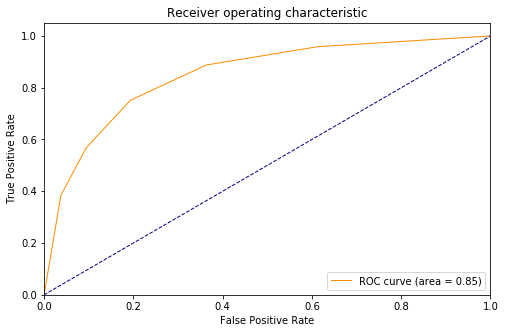

In [20]:
# Plot ROC Curve
fpr2, tpr2, _ = roc_curve(y_SAT_test, y_SAT_prob2[:,1] )
roc_auc2 = auc(fpr2, tpr2)
lw=1

plt.figure(figsize=(8,5));
plt.plot(fpr2, tpr2, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc2)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


# SAT Model #3 :  SVC Classifier

In [21]:
param_grid = [
    {
         'reduce_dim__k': N_FEATURES_OPTIONS,
         'clf': [SVC(probability=True)],
         'clf__C': C_OPTIONS,
         'clf__random_state':[123]
     }
]

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=k_fold,n_jobs=-1, verbose=1, scoring='roc_auc' )

SAT_SVC_model = grid_search.fit(X_SAT_train, y_SAT_train)

y_SAT_score3 = grid_search.predict(X_SAT_test)
y_SAT_prob3=grid_search.predict_proba(X_SAT_test)

print(roc_auc_score(y_SAT_test, y_SAT_prob3[:,1]))

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   19.3s finished


0.8975103271184549


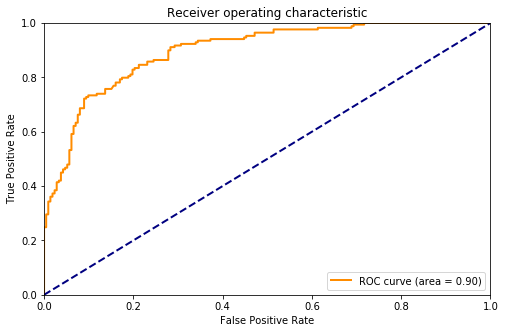

In [22]:
# Plot ROC Curve
from sklearn.metrics import roc_curve, auc
fpr3, tpr3, _ = roc_curve(y_SAT_test, y_SAT_prob3[:,1] )
roc_auc3 = auc(fpr3, tpr3)
lw=2

plt.figure(figsize=(8,5));
plt.plot(fpr3, tpr3, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc3)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Crime Models
For the crime model we tried 5 different algorithms to create a model which has superior prediction capabilities based on the ROC/AUC scoring parameter:
* Logistic Regression
* Feature Bagging
* Gradient Boosting
* ADA Boosting
* Random Forest Classification

We created a ROC/AUC plot for each model and summarized our findings based on the combined results for these different models.

# Crime Model #1: Gradient Boosting

In [23]:
 param_grid = [
    {
         'reduce_dim__k': N_FEATURES_OPTIONS,
         'clf':[GradientBoostingClassifier()],
         'clf__n_estimators': C_ESTIMATORS, 
         'clf__max_depth': C_DEPTH,
         'clf__learning_rate':LEARNING_RATE,
         'clf__random_state':[123]
     }
]


# # This will test the parameter dict against our 
# # pipeline

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=k_fold,n_jobs=-1, verbose=1, scoring='roc_auc' )


# # Here we are training the model, this is 
# # what takes the most amount of time to run
crime_GradientBoost_model = grid_search.fit(X_crime_train, y_crime_train)


y_crime_GradientBoost_score = grid_search.predict(X_crime_test)
y_crime_GradientBoost_prob = grid_search.predict_proba(X_crime_test)
print(roc_auc_score(y_crime_test, y_crime_GradientBoost_prob[:,1]))


Fitting 10 folds for each of 144 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 338 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 688 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done 1138 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  1.3min finished


0.729969333705046


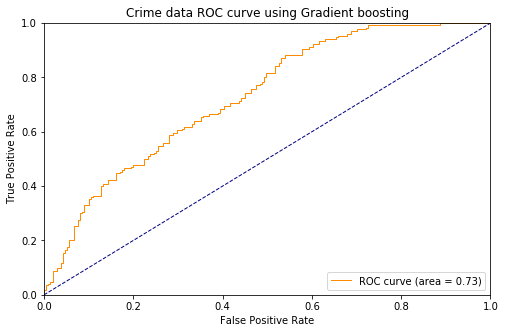

In [24]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_crime_test, y_crime_GradientBoost_prob[:,1])
roc_auc = auc(fpr, tpr)
lw=1

plt.figure(figsize=(8,5));
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Crime data ROC curve using Gradient boosting')
plt.legend(loc="lower right")
plt.show()

# Crime Model #2: ADA Boost

In [25]:
 param_grid = [
    {
         'reduce_dim__k': N_FEATURES_OPTIONS,
         'clf': [AdaBoostClassifier()],
         'clf__n_estimators': C_ESTIMATORS,
         'clf__learning_rate':LEARNING_RATE,
         'clf__random_state':[123]
     }
]


# # This will test the parameter dict against our 
# # pipeline

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=k_fold,n_jobs=-1, verbose=1, scoring='roc_auc' )


# # Here we are training the model, this is 
# # what takes the most amount of time to run
crime_ADABoost_model = grid_search.fit(X_crime_train, y_crime_train)

y_crime_ADABoost_score = grid_search.predict(X_crime_test)
y_crime_ADABoost_prob = grid_search.predict_proba(X_crime_test)

print(roc_auc_score(y_crime_test, y_crime_ADABoost_prob[:,1]))


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 338 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   32.2s finished


0.7112350153331474


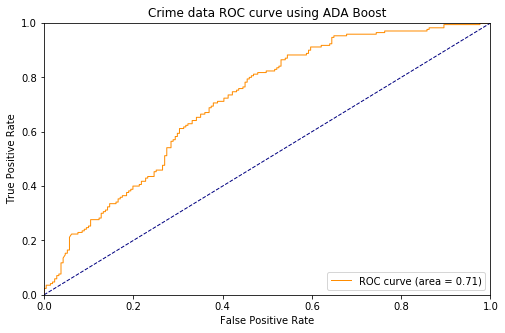

In [26]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_crime_test, y_crime_ADABoost_prob[:,1] )
roc_auc = auc(fpr, tpr)
lw=1

plt.figure(figsize=(8,5));
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Crime data ROC curve using ADA Boost')
plt.legend(loc="lower right")
plt.show()

# Crime Model #3: Random Forest Classifier

In [27]:
 param_grid = [
    {
         'reduce_dim__k': N_FEATURES_OPTIONS,
         'clf': [RandomForestClassifier()],
         'clf__n_estimators': C_ESTIMATORS, 
         'clf__max_depth': C_DEPTH,
         'clf__random_state':[123]
     }
]


# # This will test the parameter dict against our 
# # pipeline

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=k_fold,n_jobs=-1, verbose=1, scoring='roc_auc' )


# # Here we are training the model, this is 
# # what takes the most amount of time to run
crime_RandomForest_model = grid_search.fit(X_crime_train, y_crime_train)

y_crime_RandomForest_score = grid_search.predict(X_crime_test)
y_crime_RandomForest_prob = grid_search.predict_proba(X_crime_test)

print(roc_auc_score(y_crime_test, y_crime_RandomForest_prob[:,1]))

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 338 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   12.5s finished


0.7020072483969891


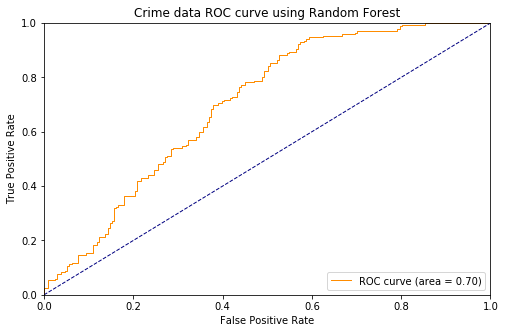

In [28]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_crime_test, y_crime_RandomForest_prob[:,1] )
roc_auc = auc(fpr, tpr)
lw=1

plt.figure(figsize=(8,5))
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Crime data ROC curve using Random Forest')
plt.legend(loc="lower right")
plt.show()

# Crime Model #4: Logistic Regression

In [29]:

param_grid = [
    {
         'reduce_dim__k': N_FEATURES_OPTIONS,
         'clf': [LogisticRegression()],
         'clf__C': [1e-3,1e-2,1e-1,1e0,1e1,1e2],
         'clf__random_state':[123] 
     }
]


# # This will test the parameter dict against our 
# # pipeline

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=k_fold,n_jobs=-1, verbose=1, scoring='roc_auc' )


# # Here we are training the model, this is 
# # what takes the most amount of time to run
crime_LogicReg_model = grid_search.fit(X_crime_train, y_crime_train)

y_crime_LogicReg_score = grid_search.predict(X_crime_test)
y_crime_LogicReg_prob = grid_search.predict_proba(X_crime_test)

print(roc_auc_score(y_crime_test, y_crime_LogicReg_prob[:,1]))

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   14.0s finished


0.6913298020630053


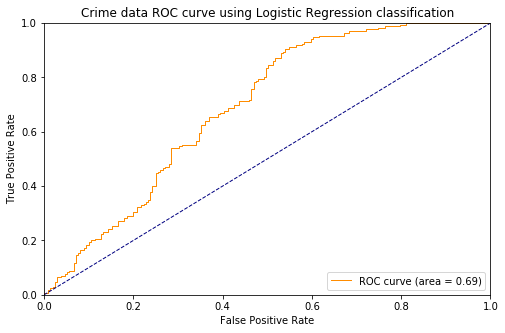

In [30]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_crime_test, y_crime_LogicReg_prob[:,1] )
roc_auc = auc(fpr, tpr)
lw=1

plt.figure(figsize=(8,5));
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Crime data ROC curve using Logistic Regression classification')
plt.legend(loc="lower right")
plt.show()

# Crime Model #5: Bagging Method

In [31]:
param_grid = [
    {
         'reduce_dim__k': N_FEATURES_OPTIONS,
         'clf': [BaggingClassifier(DecisionTreeClassifier())],
         'clf__n_estimators': C_ESTIMATORS,
         'clf__random_state':[123] 
     }
]


# # This will test the parameter dict against our 
# # pipeline

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=k_fold,n_jobs=-1, verbose=1, scoring='roc_auc')


# # Here we are training the model, this is 
# # what takes the most amount of time to run
crime_Bagging_model = grid_search.fit(X_crime_train, y_crime_train)

y_crime_Bagging_score = grid_search.predict(X_crime_test)
y_crime_Bagging_prob = grid_search.predict_proba(X_crime_test)

print(roc_auc_score(y_crime_test, y_crime_Bagging_prob[:,1]))

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  1.2min finished


0.7316699191524951


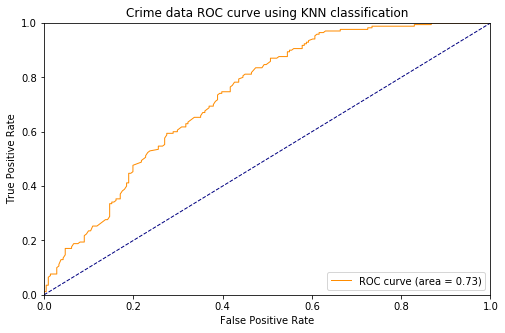

In [32]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_crime_test, y_crime_Bagging_prob[:,1] )
roc_auc = auc(fpr, tpr)
lw=1

plt.figure(figsize=(8,5));
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Crime data ROC curve using KNN classification')
plt.legend(loc="lower right")
plt.show()

# 2.d Modeling and Evaluation

## Crime ROC Model comparison
When we plot all ROC curves on the same chart we can see some evidence that all models are providing the same type of results.  The ADA Boost Classifier appears to have a slightly better rate of True Positive vs False Positive classification

### Intepretation of SAT models

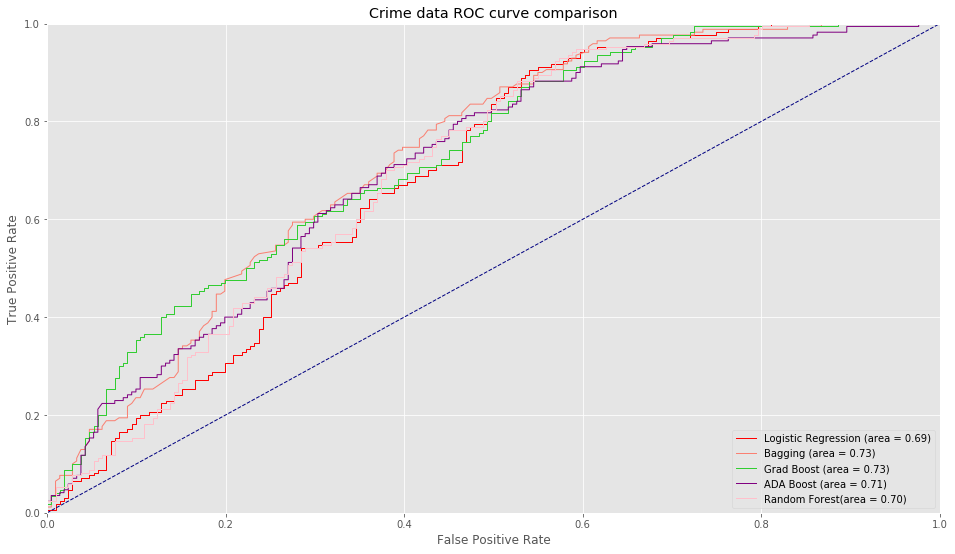

In [68]:
# Plot ROC Curve
fpr1, tpr1, _ = roc_curve(y_crime_test, y_crime_LogicReg_prob[:,1] )
fpr2, tpr2, _ = roc_curve(y_crime_test, y_crime_Bagging_prob[:,1] )
fpr3, tpr3, _ = roc_curve(y_crime_test, y_crime_GradientBoost_prob[:,1])
fpr4, tpr4, _ = roc_curve(y_crime_test, y_crime_ADABoost_prob[:,1])
fpr5, tpr5, _ = roc_curve(y_crime_test, y_crime_RandomForest_prob[:,1])
lw=1

plt.figure(figsize=(16,9));
plt.plot(fpr1, tpr1, color='red', lw=1, label='Logistic Regression (area = %0.2f)' % auc(fpr1, tpr1))
plt.plot(fpr2, tpr2, color='salmon', lw=1, label='Bagging (area = %0.2f)' % auc(fpr2, tpr2))
plt.plot(fpr3, tpr3, color='limegreen', lw=1, label='Grad Boost (area = %0.2f)' % auc(fpr3, tpr3))
plt.plot(fpr4, tpr4, color='purple', lw=1, label='ADA Boost (area = %0.2f)' % auc(fpr4, tpr4))
plt.plot(fpr5, tpr5, color='pink', lw=1, label='Random Forest(area = %0.2f)' % auc(fpr5, tpr5))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Crime data ROC curve comparison')
plt.legend(loc="lower right")

plt.show()

### Intepretation of crime models

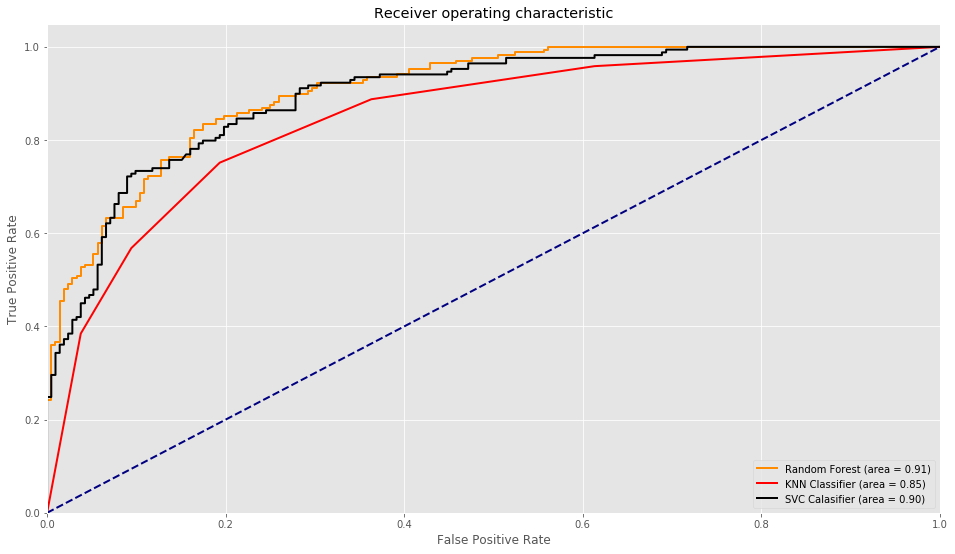

In [69]:
#SAT Models Comparison with ROC curves for all 3 models:
fpr1, tpr1, _ = roc_curve(y_SAT_test, y_SAT_prob1[:,1] )
roc_auc1 = auc(fpr1, tpr1)
fpr2, tpr2, _ = roc_curve(y_SAT_test, y_SAT_prob2[:,1] )
roc_auc2 = auc(fpr2, tpr2)
fpr3, tpr3, _ = roc_curve(y_SAT_test, y_SAT_prob3[:,1] )
roc_auc3 = auc(fpr3, tpr3)
lw=2


plt.figure(figsize=(16,9));
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label='Random Forest (area = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, color='red', lw=2, label='KNN Classifier (area = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, color='black', lw=2, label='SVC Calasifier (area = %0.2f)' % roc_auc3)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# 2.e Modeling and Evaluation

Models we implemented thus far: 

1. **K-Nearest Neighbor**<br>
        Advantage:
            -Model does not need to be trained and incremental learning is done when new data is fed in. 
        Disadvantage:
            -Does not handle large number of dimensions.
            -Weighing of attributes needs to be done. Additional work.
            -memory intensive. 

2. **SVM**<br>
        Advantage: 
            -Can handle large number of dimensions. 
            -Many kernels to choose from. 
            -Fairly robust against overfitting. 
        Disadvantage:
            -Memory intensive and time consuming.
            -Parameterization is hard.  

3. **Random Forest** <br>
        Advantage: 
            -Robust to overfitting. 
            -Performs well with large number of features.
        Disadvantage: 
            -Learning is slow and integration to improve generated models is not possible. 

4. **Logistic Regression** <br>
        Advantage: 
            -Output is very informative compared to most models. 
            -Two important measures: Coefficient size (how relevant) and positive/negative (direction of association)
        Disadvantage: 
            -Not as flexible as other models. 
            -High Bias
            -Underperform when non-linear decision boundaries exist. 

5. **Feature Bagging** <br>
        Advantage: 
            -Provides variable importance measure: Gini Index
            -Handles categorical features with ease. 
        Disadvantage: 
            -Visual interpretation is difficult.
            -Unable to reduce variance if the features are correlated. 

6. **Boosting** <br>
        Advantage: 
            -Good parameterization (easy). 
            -Robust to overfitting and performs well with large amounts of data. 
        Disadvantage: 
            -Training is time consuming and takes a lot of memory depending on the dependence of a weak predictor. 

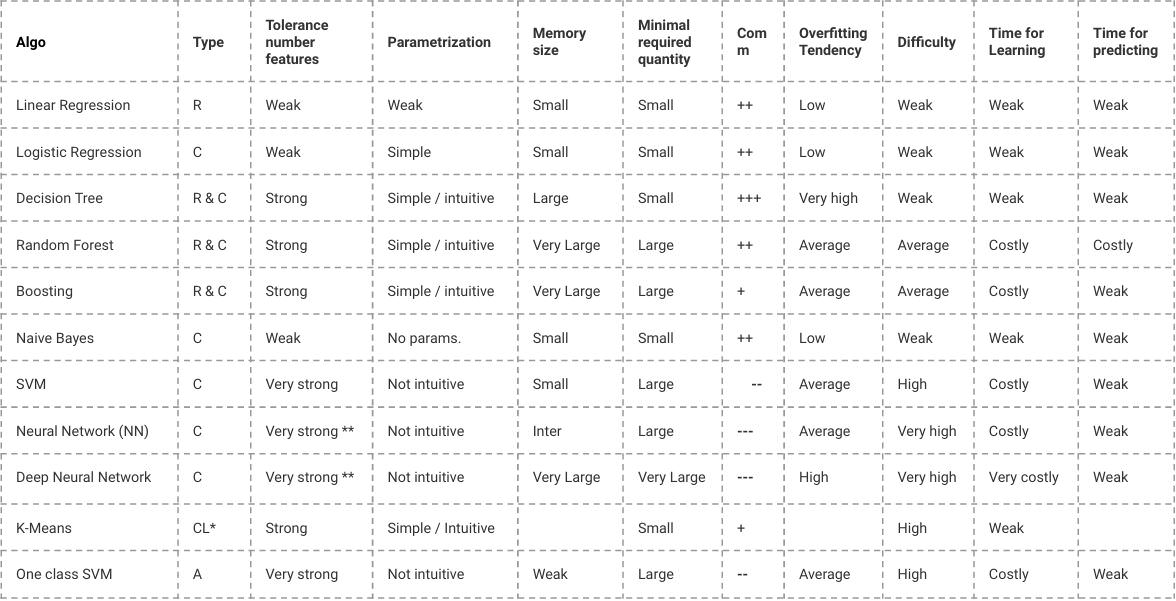

In [35]:
display(Image('https://i.imgur.com/xVZsPXl.jpg', width=900, unconfined=True))

Sources: 
http://horicky.blogspot.com/2012/02/characteristics-of-machine-learning.html 

https://victorfang.wordpress.com/2011/05/10/advantages-and-disadvantages-of-logistic-regression/

https://www.quora.com/What-are-the-advantages-of-logistic-regression

https://elitedatascience.com/machine-learning-algorithms

https://stats.stackexchange.com/questions/18891/bagging-boosting-and-stacking-in-machine-learning

https://recast.ai/blog/machine-learning-algorithms/2/   (Table Source) 

# Statistical Comparison of Classification Model (from BLT 7.5): 

in case image doesn't show, equations restated: 

$$\sigma^2 = \frac{e(1-e)}{n}$$ 

$$CI = (e_1-e_2)+-1.96\sqrt{(\sigma_1^2+\sigma_2^2)}$$


## Comparison of SAT Models: 
### Compute variance for each SAT model we are comparing
##### K-Nearest Neighbor error and variance
$\sigma^2 = \frac{e(1-e)}{n}$ <br><br>
$e = .16$ <br><br>
$\frac{(.16)(1-.16)}{1904} = .00007058$<br><br>
    
##### SVM error and variance
$\sigma^2 = \frac{e(1-e)}{n}$ <br><br>
$e =.08$<br><br>
$\frac{(.08)(1-.08)}{1904} = .00003865$<br><br>

##### Random Forest error and variance
$\sigma^2 = \frac{e(1-e)}{n}$ <br><br>
$e =.07$<br><br>
$\frac{(.07)(1-.07)}{1904} = .000034195$<br><br>

### Compute Confidence intervals of various SAT models

##### K-Nearest Neighbor compared to SVM
$(.16-.08)\pm1.96\sqrt{(.00007058+.00003865)} = [0.05951, 0.10048]$<br>
Our confidence interval does not contain 0 so we are 95% confident that these two models are not the same.<br>

#####  SVM compared to Random Forest
$(.08-.07)\pm1.96\sqrt{(.00003865+.00003419)} = [0.02672, 0.06993]$<br>
Our confidence interval does not contain 0 so we are 95% confident that these two models are not the same.<br>




## Comparison of Crime Classification Models

### Compute variance for each Crime model we are comparing
##### Gradient Boost error and variance
$\sigma^2 = \frac{e(1-e)}{n}$ <br><br>
$e =.23$<br><br>
$\frac{(.23)(1-.23)}{1904} = .00009301$<br><br>
 
 ##### ADA boost error and variance
$\sigma^2 = \frac{e(1-e)}{n}$ <br><br>
$e =.25$<br><br>
$\frac{(.25)(1-.25)}{1904} = .00009848$<br><br>
 
 ##### Random Forst error and variance
$\sigma^2 = \frac{e(1-e)}{n}$ <br><br>
$e =.25$<br><br>
$\frac{(.25)(1-.25)}{1904} = .00009848$<br><br>

 #### Bagging Model error and variance
$\sigma^2 = \frac{e(1-e)}{n}$ <br><br>
$e =.23$<br><br>
$\frac{(.23)(1-.23)}{1904} = .00009301$<br><br>
 
 ### Compute Confidence intervals of various Crime models
 ##### Gradient Boost compared to ADA Boost
$(.23-.25)\pm1.96\sqrt{(.00009301 + .00009848)} = [-0.04712, 0.00712]$<br> 
Our confidence interval does contain zero, so we are 95% confident these two models are the same <br>
 
##### Gradient Boost compared to Random Forest
$(.23-.25)\pm1.96\sqrt{(.00009301 +.00009848)} = [-0.04712, 0.00712]$<br>
Our confidence interval does contain zero, so we are 95% confident these two models are the same <br>

##### Random Forest compared to ADA Boost
$(.25-.25)\pm1.96\sqrt{(.00009848 + .00009848)} = [-0.027, 0.027]$<br>
Our confidence interval does contain zero so we are 95% confident these two models are the same <br>

##### ADA Boost compared to Bagging
$(.23-.25)\pm1.96\sqrt{(.00009301 + .00009848)} = [-0.04712, 0.00712]$<br>
Our confidence interval does contain zero, so we are 95% confident these two models are the same <br>
 

#### Conclusions on Crime model comparisons
We forgo comparing each model as the accuracy rates for the various models of either .77 or .75. It should come as no surprise that all the models are statisticlly the same.  Our accuracy rate is not very high and with each of the models accurracy rates being so close to each other, the results we recieved were what we expected.

# Feature Importance for the Top Performing Model
We identified Random Forest and Bagging classifiers are the best performing classifiers to differentiate the two classes of SAT scores and Crime in our dataset. In this part, we proceed to find the below information:

- Level of importance of each feature in this model. 
- Select relevant feature (variable) to guarantee best model performances using recursive feature elimination.

Feature selection is a process where you automatically select those features that contribute most to the outcome we are trying to predict. 

Having irrelevant features in the data can decrease the accuracy of the models. Some of the benefits of feature selection include reduce overfitting, improving accuracy and minimizing computing time.

The features that have the biggest impact on the model performance for each of these two models are evaluated.


* All features are scaled in the model.
* The coefficient values indicate the level of feature influence on model performance, higher value means stronger influence and importance.
* The influence values are sorted and top 20 features with strongest influences are plotted.

# Feature Evaluation for the top performing SAT Model: Random Forest Classifier

The list of top 20 features and their level of importance is illustrated in here:

In [36]:
# set the parameters of this estimator and fit the model
pipe.set_params(**SAT_RandomForest_model.best_params_)
pipe.fit(X_SAT_train, y_SAT_train)

coef = pipe.steps[2][1].feature_importances_

mask = pipe.steps[0][1].get_support()
new_features=[]
feature_names=list(X_SAT_train.columns.values)
for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)

#Creates a new dataframe with the coefficients and the features 
predicted_data = pd.DataFrame(data=coef,index=new_features,columns=['Influence'])
print("The top 20 features that influence SAT Score are the following")
display(predicted_data.sort_values(by='Influence', ascending=False)[0:20])

The top 20 features that influence SAT Score are the following


,Influence
ACTMath_ACTBenchmark_All,0.049610
ACTScience_ACTBenchmark_All,0.045614
ACTScience_ACTBenchmark_Male,0.042783
ACTMath_ACTBenchmark_Male,0.040639
ACTEnglish_ACTBenchmark_Female,0.031924
ACTCompositeScore_UNCMin_Female,0.030339
EOCSubjects_CACR_All,0.029635
ACTSubtests_BenchmarksMet_AIG,0.028821
ACTMath_ACTBenchmark_White,0.026516
ACTSubtests_BenchmarksMet_White,0.024135


The bar charts that visualize the Influence of 20 features with strongest impact on the performance of SAT Random Forest model are also shown here:


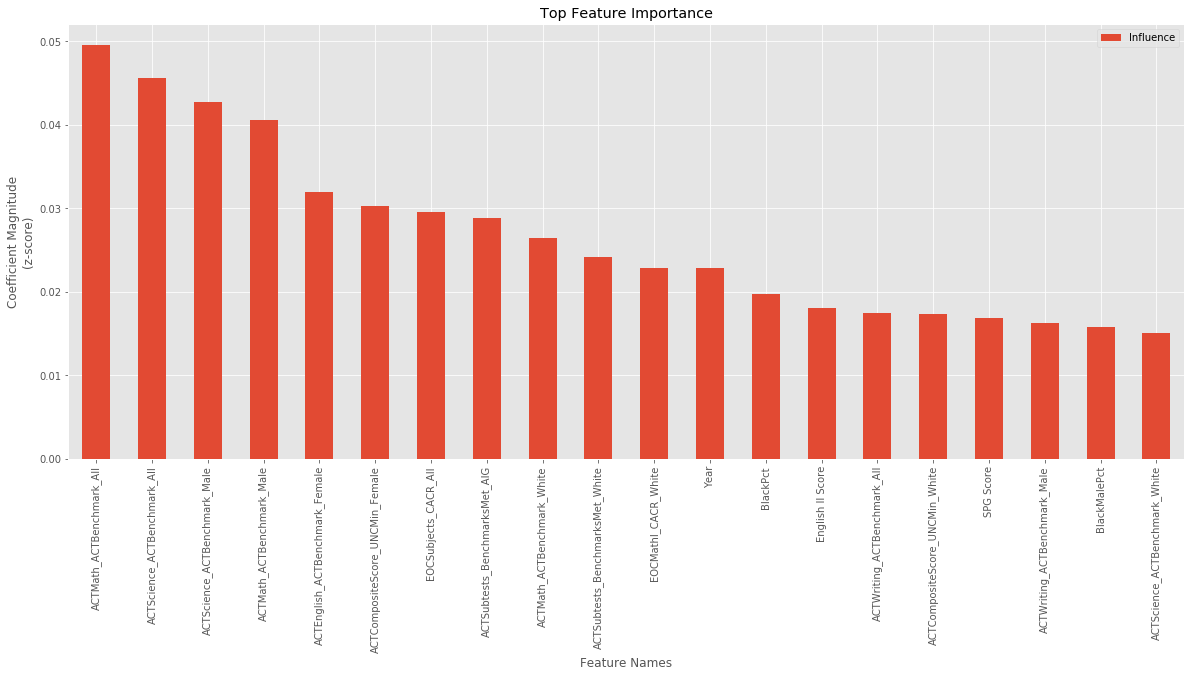

In [37]:
plt.style.use('ggplot')
Importances=predicted_data.sort_values(by='Influence', ascending=False)[0:20]
wt_plt_df = predicted_data.head(75)

weights = pd.Series(wt_plt_df['Influence'].values,index=wt_plt_df.index)
ax = Importances.plot(kind='bar', figsize=(20,8))




ax.set_title("Top Feature Importance")
ax.set_ylabel("Coefficient Magnitude\n(z-score)")
ax.set_xlabel("Feature Names")
plt.show()

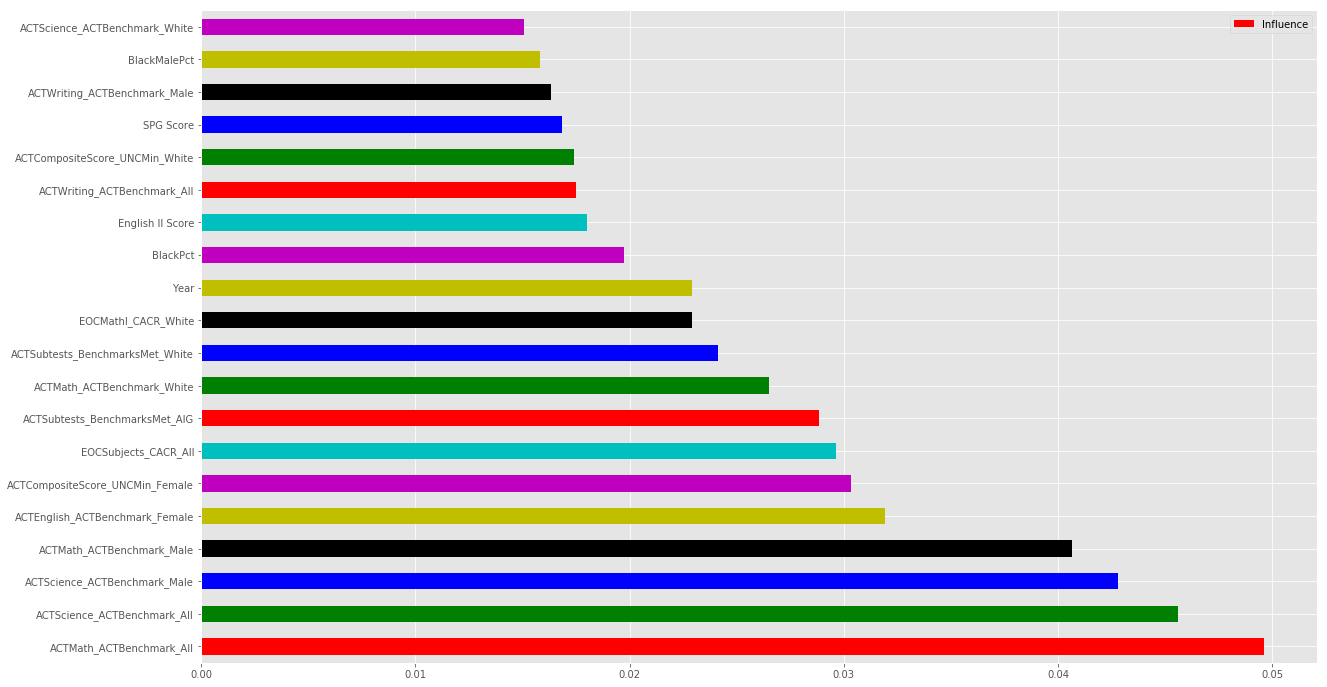

In [38]:
predicted_data.sort_values(by='Influence', ascending=False)[0:20].plot(kind='barh', figsize=(20,12), color='rgbkymc');

By looking at the table and graphs, the most important feature is "ACTMath_ACTBenchmark_All" which has the highest importance value. 

# Recursive Feature Elimination

All of our models in both tasks, already include dimentionality reduction and feature scaler. Therefore, teh models are already use the best parameters and are using the optimal number of features to achieve the best perfomance. 

In this part we perform a different type of feature elimination method just to illustrate the most important features and the accuracy of the test. We also use the same metric, ROC, in this part too.

In [39]:
model = RandomForestClassifier()
model.fit(X_SAT_train, y_SAT_train)
 
# make predictions for test data and evaluate
pred_y = model.predict(X_SAT_test)
predictions = [round(value) for value in pred_y]
accuracy = roc_auc_score(y_SAT_test, predictions)
print("RFC Accuracy: %.2f%%" % (accuracy * 100.0))
 
# fit model using each importance as a threshold
thresholds = np.sort(model.feature_importances_)[::-1]

top_accuracy=0
accuracy_plot = []

for thresh in thresholds:
      
    # selecting features using threshold
    selection = SelectFromModel(model, threshold=thresh,prefit=True)
    select_train_X = selection.transform(X_SAT_train)

    # training model
    selection_model = RandomForestClassifier(random_state=123, max_depth=5, n_estimators=100)
    selection_model.fit(select_train_X, y_SAT_train)
    
    # evaluating model
    select_test_x = selection.transform(X_SAT_test)
    pred_y = selection_model.predict(select_test_x)
    predictions = [round(value) for value in pred_y]
    accuracy = roc_auc_score(y_SAT_test, predictions)
    #print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_train_x.shape[1], accuracy*100.0))
    if accuracy > top_accuracy:
        top_accuracy = accuracy
    if thresh > 0.000:
        accuracy_plot.append(accuracy)
print(round(top_accuracy,5))


RFC Accuracy: 81.38%
0.83985


As shown in the line chart below, The optimal number of features is around 35 features that result in creating the model with more than 89% of accuracy. 
Using only 35 features give us a less complex model along with the maximum accuracy.


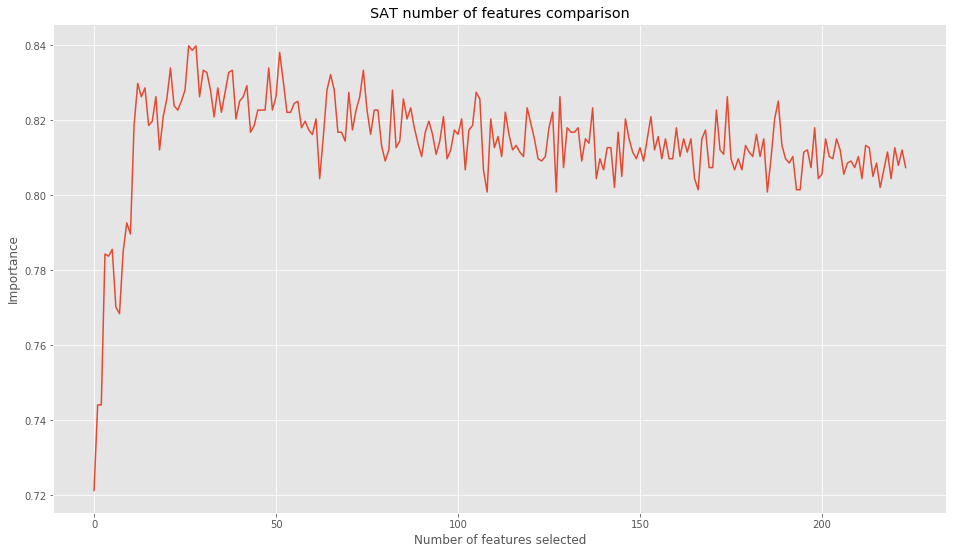

In [40]:
plt.figure(figsize=(16,9));
plt.plot(accuracy_plot);
plt.title('SAT number of features comparison')
plt.xlabel("Number of features selected")
plt.ylabel("Importance")

plt.show()


#  Feature Evaluation for the top Performing Crime Model: Gradient Boost Classifier

The list of top 20 features and their level of importance is illustrated in here:


In [41]:
# set the parameters of this estimator and fit the model
pipe.set_params(**crime_GradientBoost_model.best_params_);
pipe.fit(X_crime_train, y_crime_train)

coef = pipe.steps[2][1].feature_importances_


mask = pipe.steps[0][1].get_support()
new_features=[]
feature_names=list(X_crime_train.columns.values)
for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)

#Creates a new dataframe with the coefficients and the features
predicted_data = pd.DataFrame(data=coef,index=new_features,columns=['Influence'])
print("The top 10 features that influence improved crime rates for a school are the following")



display(predicted_data.sort_values(by='Influence', ascending=False)[0:20])

The top 10 features that influence improved crime rates for a school are the following


,Influence
avg_daily_attend_pct,0.067085
short_susp_per_c_num,0.031023
cte_courses,0.017280
EVAAS Growth Score,0.016647
advance_dgr_pct,0.015928
_1yr_tchr_trnovr_pct,0.014726
EOCMathI_CACR_Black,0.013412
SPG Score,0.012420
long_susp_per_c_num,0.012392
BlackFemalePct,0.012038


The top 20 features are ordered by their importance. Average daily attendance percentage at school level explains the accuracy of target variable more than other attributes and it counts for around 7% of feature importance. With more attendance percentage at school we observe less crime. 

The next attribute that has the highest importance rank is "short_susp_per_c_num" which is the short-term suspensions per 100 students at school level. These short-term suspensions are less serious offenses and can last up to ten days. It plays a big role in predicting either the crime at school level is higher or lower than LEA level.

Similarly, the Cte_courses are another feature that has a strong impact on the performance of the model. It shows the percent of students enrolled in at least one career and technical education (CTE) course at the school level. 

By going down the ranking table provided above, we see obvious relationships between the feature and the crime response variable.

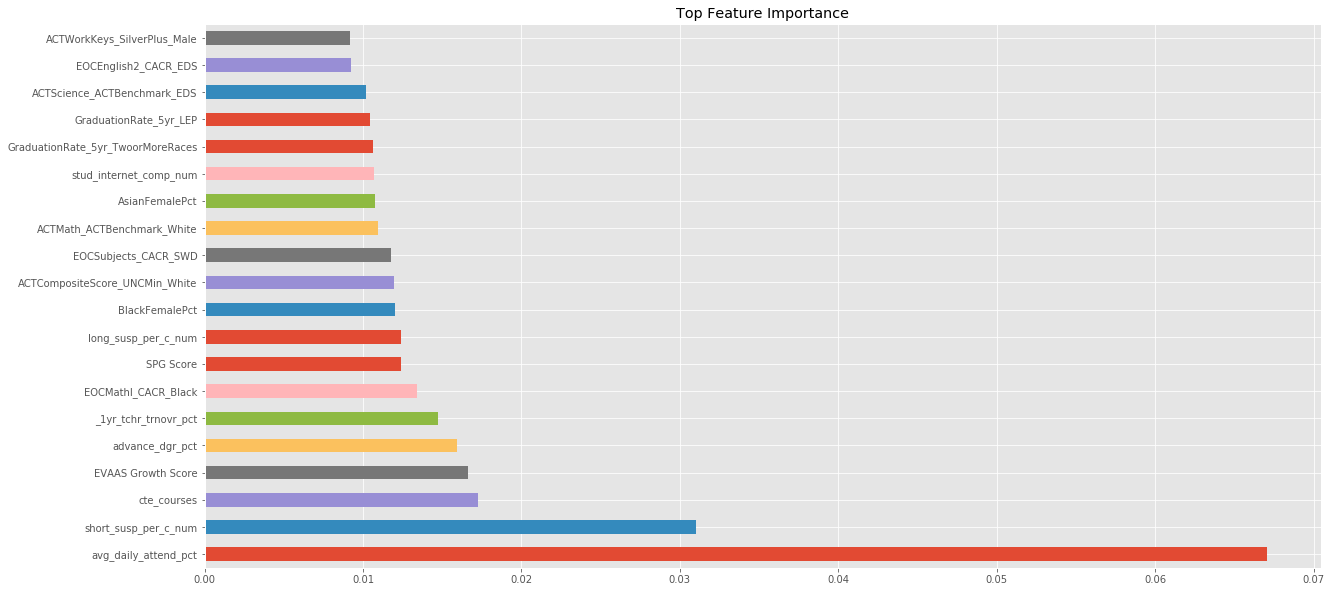

In [42]:
# Crerate the bar chart with the 20 most important features
feat_importances = pd.Series(pipe.steps[2][1].feature_importances_, index=X_crime_train.columns)
feat_importances = feat_importances.nlargest(20)

ax = feat_importances.plot(kind='barh', figsize=(20,10))

ax.set_title("Top Feature Importance");

#  Coefficient Influence Using Logistic Regression

Logistic Regression is performed in this rpoject to identify the positive and negative impact of each feature on response variable. 
The table below shows the top 20 features that their absolute value coefficient are highest. 

In [43]:
pipe.set_params(**crime_LogicReg_model.best_params_)
pipe.fit(X_crime_train, y_crime_train)

clf = pipe.steps[2][1]

abs_coef = np.asarray([abs(x) for x in clf.coef_ ])
mask = pipe.steps[0][1].get_support()
new_features=[]
feature_names=list(X_crime_train.columns.values)
for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)

#Creates a new dataframe with the coefficients and the features

predicted_data = pd.DataFrame({'Coefficient':clf.coef_[0],'abs_Influence':abs_coef[0]},index=new_features )
print("The top 10 features that influence improved crime rates for a school are the following")
predicted_data = predicted_data.sort_values(by='abs_Influence', ascending=False).drop('abs_Influence',axis=1,)
display(predicted_data[0:20])

The top 10 features that influence improved crime rates for a school are the following


,Coefficient
long_susp_per_c_num,0.049050
SPG Score,-0.046525
TotalTargets_pTarget_PctMet,-0.046419
avg_daily_attend_pct,-0.045617
cte_courses,0.039380
advance_dgr_pct,-0.033490
grade_range_cd_K-12,0.033272
GraduationRate_4yr_SWD,0.033128
univ_college_courses,-0.032790
EOCMathI_CACR_Black,-0.032628


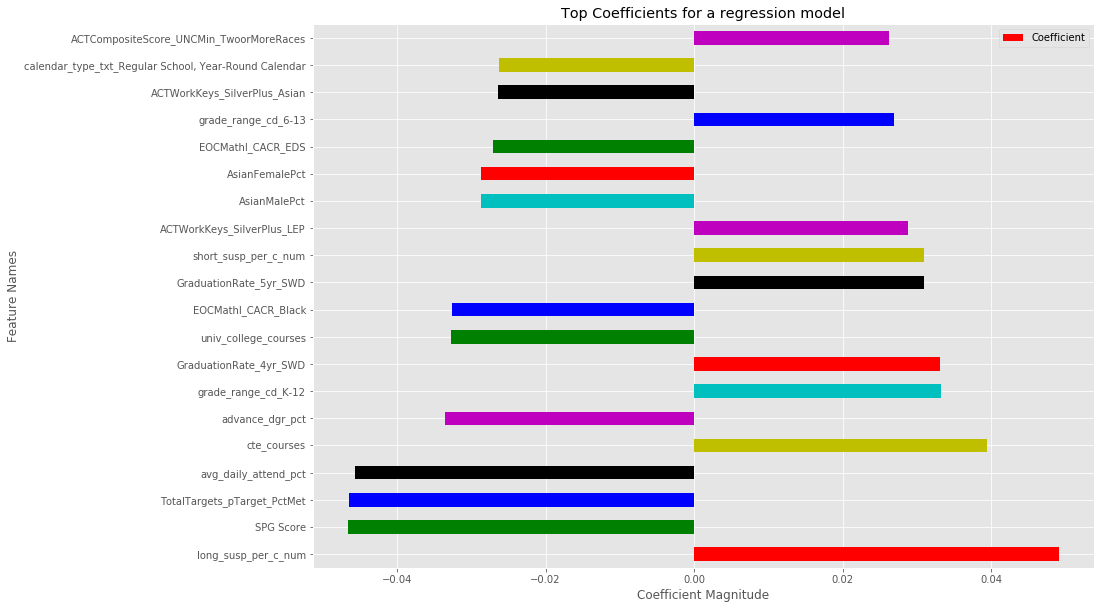

In [44]:
plt.style.use('ggplot')
Importances=predicted_data[0:20]
wt_plt_df = predicted_data.head(10)


ax = Importances.plot(kind='barh', color='rgbkymc', figsize=(14,10))


ax.set_title("Top Coefficients for a regression model")
ax.set_xlabel("Coefficient Magnitude")
ax.set_ylabel("Feature Names")
plt.show()

# Recursive Feature Elimination

In [45]:
model = GradientBoostingClassifier()
model.fit(X_crime_train, y_crime_train)
 
# make predictions for test data and evaluate
pred_y = model.predict(X_crime_test)
predictions = [round(value) for value in pred_y]
accuracy = roc_auc_score(y_crime_test, predictions)
print("RFC Accuracy: %.2f%%" % (accuracy * 100.0))
 
# fit model using each importance as a threshold
thresholds = np.sort(model.feature_importances_)[::-1]

top_accuracy=0
accuracy_plot = []

for thresh in thresholds:
      
    # selecting features using threshold
    selection = SelectFromModel(model, threshold=thresh,prefit=True)
    select_train_X = selection.transform(X_crime_train)

    # training model
    selection_model = GradientBoostingClassifier(random_state=123,
                                                 max_depth=5, n_estimators=100)
    selection_model.fit(select_train_X, y_crime_train)
    
    # evaluating model
    select_test_x = selection.transform(X_crime_test)
    pred_y = selection_model.predict(select_test_x)
    predictions = [round(value) for value in pred_y]
    accuracy = roc_auc_score(y_crime_test, predictions)
    #print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_train_x.shape[1], accuracy*100.0))
    if accuracy > top_accuracy:
        top_accuracy = accuracy
    if thresh > 0.000:
        accuracy_plot.append(accuracy)
print(round(top_accuracy,5))

RFC Accuracy: 64.05%
0.67538


As shown in the line chart below, The optimal number of features is around 90 features that result in creating the model with more than 74% of accuracy. 
Using only the top 90 features give us a less complex model along with the maximum accuracy.

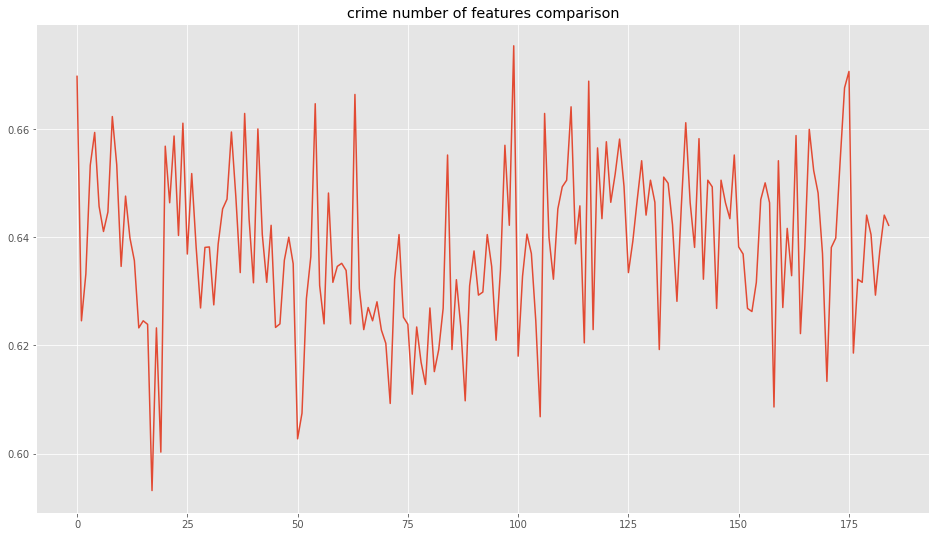

In [46]:
plt.figure(figsize=(16,9));
plt.plot(accuracy_plot);
plt.title('crime number of features comparison')
plt.show()


# Reduced scope model

In [47]:
list_of_keywords=['LEP','EDS','[Ww]hite','[Mm]ale','[Pp]acific[Ii]sland','[Aa]sian','[Hh]ispanic',
                  '[Rr]ace','[Bb]lack','[Mm]inority','[Tw]wo[Oo]r[Mm]ore','[Ii]ndian','[Ww]hite']

X_crime_reduced = X_crime[X_crime.columns.drop(list(X_crime.filter(regex='|'.join(list_of_keywords))))]
X_crime_reduced_train, X_crime_reduced_test, y_crime_reduced_train, y_crime_reduced_test = train_test_split(X_crime_reduced, y_crime, test_size=.2)

Based on the contributing features to the model we wanted to remove any items that could influence policy items that could be biased against a protected class, including sex and race, for the high schools in the schools specified in these North Carolina models. We wanted to remove any indicators that could possibly indicate the race of and makeup of the student body so as to not disadvantage any group of students with any recommendations for policy changes.

# Reduced method using Gradient Boost method

In [48]:
pipe.set_params(**crime_GradientBoost_model.best_params_)
pipe.fit(X_crime_reduced_train, y_crime_reduced_train)

y_crime_reduced_GradBoost_prob = pipe.predict_proba(X_crime_reduced_test)

print(round(roc_auc_score(y_crime_reduced_test, y_crime_reduced_GradBoost_prob[:,1]),5))

0.72299


In [49]:
coef = pipe.steps[2][1].feature_importances_

mask = pipe.steps[0][1].get_support()
new_features=[]
feature_names=list(X_crime_reduced_train.columns.values)
for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)

#Creates a new dataframe with the coefficients and the 
predicted_data = pd.DataFrame(data=coef,index=new_features,columns=['Influence'])
print("The top 10 features that influence SPG Grade are the following")



display(predicted_data.sort_values(by='Influence', ascending=False)[0:10])

The top 10 features that influence SPG Grade are the following


,Influence
avg_daily_attend_pct,0.059076
SPG Score,0.051419
advance_dgr_pct,0.032735
short_susp_per_c_num,0.032170
cte_courses,0.029674
unit_code,0.027642
stud_internet_comp_num,0.027544
long_susp_per_c_num,0.023152
EVAAS Growth Score,0.021684
student_num,0.019018


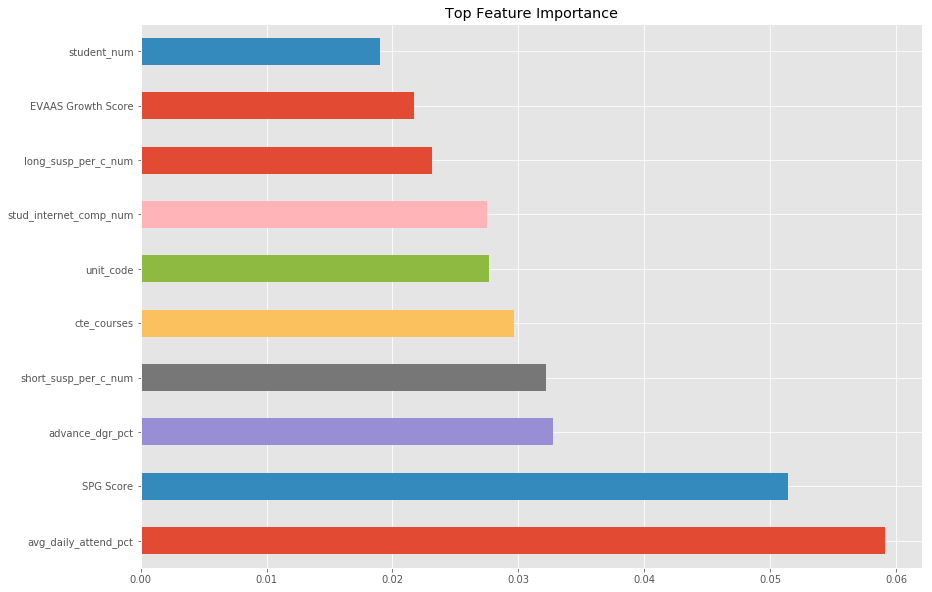

In [50]:
feat_importances = pd.Series(pipe.steps[2][1].feature_importances_, index=X_crime_reduced_train.columns)
feat_importances = feat_importances.nlargest(10)

ax = feat_importances.plot(kind='barh', figsize=(14,10))

ax.set_title("Top Feature Importance");

In [66]:
pipe.set_params(**crime_LogicReg_model.best_params_)
pipe.fit(X_crime_reduced_train, y_crime_reduced_train)

y_crime_LogReg_reduced_prob = pipe.predict_proba(X_crime_reduced_test)

print(round(roc_auc_score(y_crime_reduced_test, y_crime_LogReg_reduced_prob[:,1]),5))

0.69103


In [67]:
clf = pipe.steps[2][1]

abs_coef = np.asarray([abs(x) for x in clf.coef_ ])
mask = pipe.steps[0][1].get_support()
new_features=[]
feature_names=list(X_crime_reduced_train.columns.values)
for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)

#Creates a new dataframe with the coefficients and the 

predicted_data = pd.DataFrame({'Coefficient':clf.coef_[0],'abs_Influence':abs_coef[0]},index=new_features )
print("The top 10 features that influence improved crime rates for a school using the reduced dataset are the following")
predicted_data = predicted_data.sort_values(by='abs_Influence', ascending=False).drop('abs_Influence',axis=1,)
display(predicted_data[0:15])

The top 10 features that influence improved crime rates for a school using the reduced dataset are the following


,Coefficient
avg_daily_attend_pct,-0.084704
SPG Score,-0.076086
cte_courses,0.061957
long_susp_per_c_num,0.057922
ACTWriting_ACTBenchmark_All,-0.049709
ACTMath_ACTBenchmark_All,-0.049212
univ_college_courses,-0.048644
GraduationRate_4yr_SWD,0.047497
EOCSubjects_CACR_All,-0.046099
grade_range_cd_K-12,0.045048


$\textbf{Analysis from reduced model on local crime outcomes}$ 

We found that many of the same features that influenced local crime outcomes in the full model are similar with the reduced model. We cannot draw any causal links because these numbers were not the result of a randomized experiment, but there is obvious correlation between worse local crime results and numbers that would be influenced by problematic students, such as suspension results being higher at schools with worse crime, it is difficult to determine which is influencing the other. Schools with higher college prep scores (ACTWriting_ACTBenchmark_All) and those with students taking college courses (univ_college_courses) tend to have better crime outcomes.

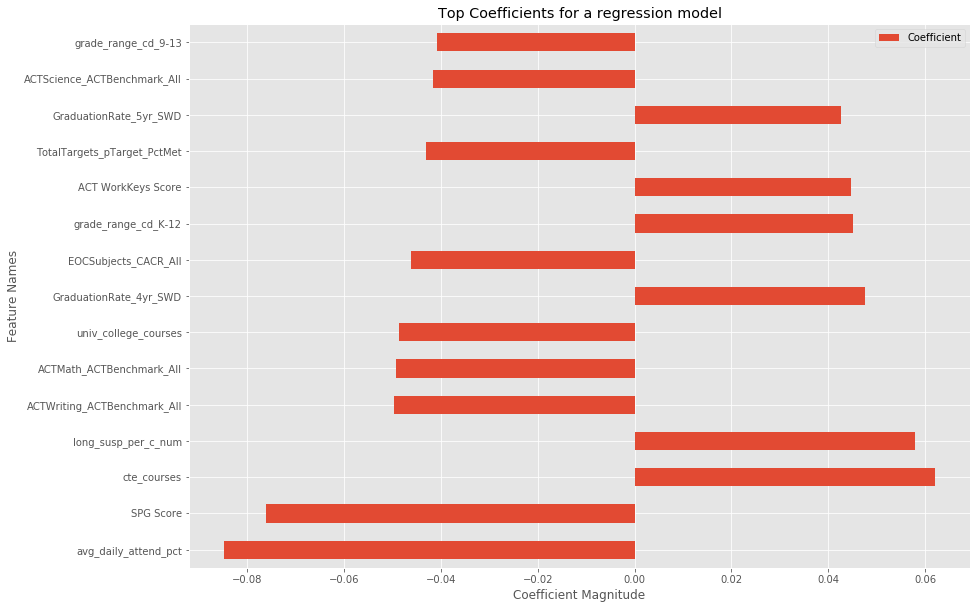

In [53]:
plt.style.use('ggplot')
Importances=predicted_data[0:15]
wt_plt_df = predicted_data.head(10)


ax = Importances.plot(kind='barh', figsize=(14,10))


ax.set_title("Top Coefficients for a regression model")
ax.set_xlabel("Coefficient Magnitude")
ax.set_ylabel("Feature Names")
plt.show()

# Deployment

$\textbf{Purpose of research}$

It is fair to say that the entirety of this data set is geared towards evaluating the school’s SPG score. Thus, the improvement feedback loop of identifying, analyzing, implementing, and following up with the schools. However, if we think deeply about this, what is SPG score really for? It is a measure of how serviceable the school is being towards the student’s preparation as a productive member of society.

$\textbf{Results of SAT research}$

One big pathway for students to be very productive members of society is to go to a university and further their education in more specialized subject matters. Thus, we took this lab assignment a step further and focused on two connected ideas that researchers have proven to be critical in a student’s success: How safe are they in their environment (crime models) and are they learning to think critically (SAT Models- we’ll go with this claim since most colleges use this as an entrance exam). 


For both tasks we used classification models with the intention of gaining actionable feature insight for schools who want to have more students going to college, or at least, able to apply to college and get in. Thus, the model is very useful to the schools, the state, the economy. 


We can easily measure the model’s value after deployment by keeping track of how many attempts to take the SAT, what scores they get, and what colleges in NC they are eligible to apply for. In the specific models above, we focused on schools that accept a minimum score of 1000 from 1600. We found several choices in NC state alone. Western Carolina University and Catawaba College accept scores of around 1000. Hence, students will not be discouraged. 


We have enough data collected. If pressed, we would add how many attempts a student makes taking the SAT and whether and the methodology of studying for it to better understand preparation procedures that would further help schools with their implementation process.

$\textbf{Results of crime research}$


# Exceptional Work

### Summary of Exceptional Work throughout the paper

$\textbf{LaTeX and HTML formatting}$ We worked on incorporating LaTeX into our paper to improve readability and to help with the flow of each section. While some of the people on the team have experience with other markup languages such as HTML, this was a new experience that took time to understand and debug.

$\textbf{Additional models tested}$  We included testing of additional models to understand more about our data, including using Logistic Regression and Bagging. The results for these were explained in our model selection section, which showed how different methods 

$\textbf{Attempted additional methods of data preprocessing}$ For each of the objects in the model we tried to use one hot encoding to see if these would improve our results for our given models. Our chosen models did not require one hot encoding, as opposed to something like neural networks, so we had the option to use either the string objects or numeric inputs. We found these changes did not result in better results, so these features were left as objects types, for ease of readability.

$\textbf{Use of gridsearch CV}$ For all of our models we used pipelines and gridsearch cross-validation to streamline our model selection. This improved our results and simplified the process of incorporating different classifiers into our workflow. The use of the gridsearch with data dictionaries made the process of testing each pipeline very easy, as well as recalling the pipeline later for additional analysis.



# Source

Explanation of ROC curves and AUC - https://www.dataschool.io/roc-curves-and-auc-explained/

Feature importance for Gradient Boosting - https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/

Getting feature importance with Bagging - https://stackoverflow.com/questions/44333573/feature-importances-bagging-scikit-learn